# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [10]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [13]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [14]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [15]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [16]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [17]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [18]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

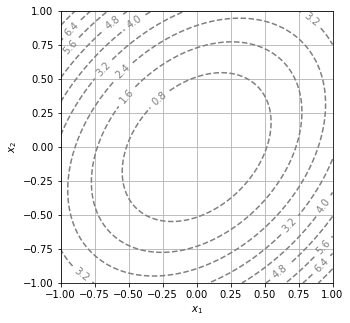

In [19]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [20]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

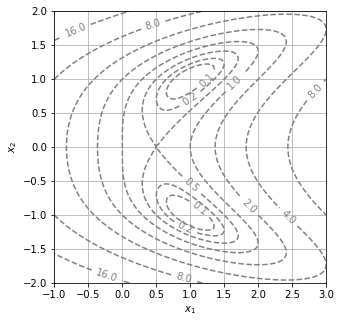

In [21]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [22]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

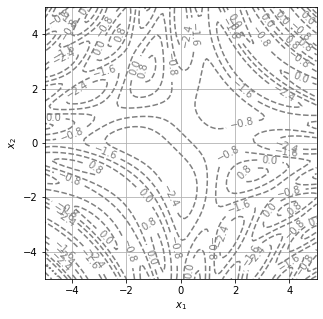

In [23]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [25]:
N = 100
eps = 10**(-5)

In [26]:
#La fonction ne demande pas d'être d'une grande précision car on cherche à tracer des courbes de niveaux, 
#et non chercher une solution exacte. 

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [27]:
def Newton(F, x0, y0, eps=eps, N=N):
    X = np.array([float(x0),float(y0)]) #autograd requiert des flotants
    x,y = 0.,0.
    jaco = J(F)
    for i in range(N):
        X = X - np.linalg.solve(jaco(x0,y0),F(x0,y0)) #plus efficace que d'inverser la jacobienne avec linalg.inv
        x, y = X[0], X[1]
        if (np.sqrt((x - x0)**2 + (y - y0)**2) <= eps).all():
            return x, y
        x0, y0 = float(x), float(y)
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

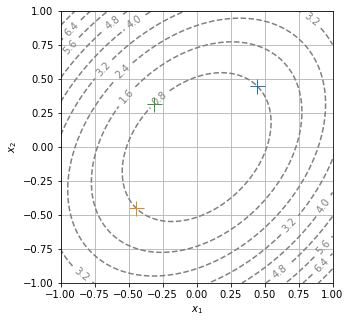

In [28]:
c = 0.8

def Fonc1(x,y):
    return np.array([f1(x,y)-c,x-y])

def Fonc2(x,y):
    return np.array([f1(x,y) - c,x+y])

a,b = Newton(Fonc1,0.8,0.8)#essai "classique"
e,f = Newton(Fonc2,0.8,0.8)#on fait varier la condition
c,d = Newton(Fonc1,0.2,-0.8)#on fait varier le point de départ


display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.plot(a,b, marker = '+', markersize=15)
plt.plot(c,d,marker = '+', markersize=15)
plt.plot(e,f,marker = '+', markersize=15)
plt.show()

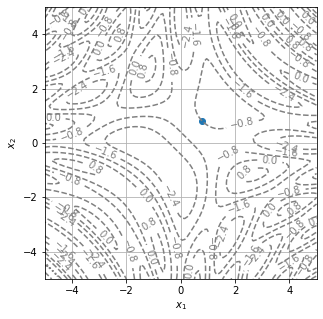

In [29]:
# On fait varier l'exemple de référence

c = -0.8

def Fonc3(x,y):
    return np.array([f3(x,y)-c,x-y])

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

x,y = Newton(Fonc3,0.8,0.3)
plt.scatter(x,y)
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [30]:
def level_curve(f,x0,y0,N,delta = 0.1):
    
    def aux(a,b):
        return np.sqrt((x - a)**2 + (y - b)**2) - delta
    
    def F(x,y):
        return np.array([f(x,y)-c,aux(x,y)])
    
    x,y = x0,y0
    vec = np.array([x,y])
    res = np.empty((N,2))
    res[0] = [x,y]
    rot = np.array([[0,1],[-1,0]]) #matrice rotation de pi/2 vers la droite
        
    for k in range(1,N):
        norm_grad = np.sqrt((grad(f)(x,y)[0])**2 + (grad(f)(x,y)[1])**2) #permet la normalisation du vecteur
        vec = delta*(1/norm_grad)*np.dot(rot,grad(f)(x,y))
        vec = Newton(F,vec[0] + x,vec[1] + y)        
        x,y = vec[0],vec[1]
        res[k] = [x,y]
        
    return res

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [31]:
def level_curve_bis(f,x0,y0,c,delta = 0.1):
    
    def aux(a,b):
        return np.sqrt((x - a)**2 + (y - b)**2) - delta
    
    def F(x,y):
        return np.array([f(x,y)-c,aux(x,y)])
    
    x,y = x0,y0
    vec = [x,y]
    res = [vec]
    rot = np.array([[0,1],[-1,0]]) #matrice rotation de pi/2 vers la droite
    
    #On calcule un permier point pour s'écarter du premier et ne pas interférer avec la condition de la boucle for
    norm_grad = np.sqrt((grad(f)(x,y)[0])**2 + (grad(f)(x,y)[1])**2) 
    vec = delta*(1/norm_grad)*np.dot(rot,grad(f)(x,y))
    vec = Newton(F,vec[0] + x,vec[1] + y)        
    x,y = vec[0],vec[1]
    res.append([x,y]) 
    
    #Si le point est trop proche du premier c'est qu'on a fait un tour complet      
    while (np.sqrt((x - x0)**2 + (y - y0)**2) > delta/4).all(): 
        
        norm_grad = np.sqrt((grad(f)(x,y)[0])**2 + (grad(f)(x,y)[1])**2) #permet la normalisation du vecteur
        vec = delta*(1/norm_grad)*np.dot(rot,grad(f)(x,y))
        vec = Newton(F,vec[0] + x,vec[1] + y)
       
        x,y = vec[0],vec[1]
        res.append([x,y])
        
    return res

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

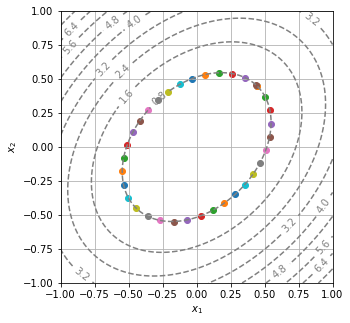

In [32]:
c = 0.8 #courbe de niveau

# fonctions qui vont permettre de trouver un premier point sur les exemples de référence
# la deuxième condition n'a en fait pas grande importance

def F2(x,y):
    return np.array([f2(x,y)-c,x-y]) 

def F3(x,y):
    return np.array([f3(x,y)-c,x-y])

# Premier exemple
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

a,b = Newton(Fonc1,0.8,0.8) #un premier point sur la courbe
plt.scatter(a,b)
res1 = level_curve_bis(f1,a,b,c)
for k in range(len(res1)):
    plt.scatter(res1[k][0],res1[k][1])
plt.show()


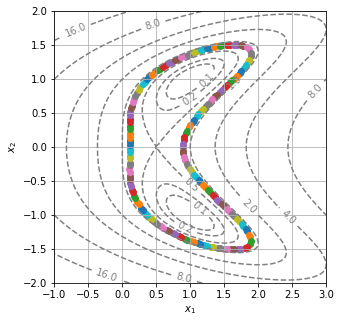

In [33]:
#Deuxième exemple
c = 0.8

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

d,e = Newton(F2,0.5,0.5)
res2 = level_curve_bis(f2,d,e,c)
for k in range(len(res2)):
    plt.scatter(res2[k][0],res2[k][1])
plt.show()

In [34]:
# Il semble y avoir une légère erreur systématique, mais uniquement sur cet exemple ...

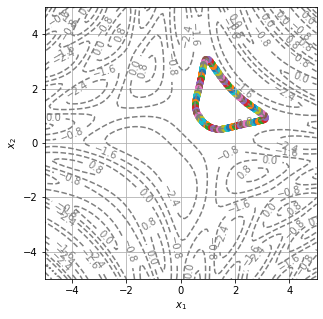

In [35]:
#Troisième exemple

c = -0.8

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

g,h = Newton(F3,0.8,0.3)
res3 = level_curve_bis(f3,g,h,-0.8)
for k in range(len(res3)):
    plt.scatter(res3[k][0],res3[k][1])
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [36]:
def area_squares(f,c,h = 0.1):
    X = np.arange(-2, 2, h)
    Y = np.arange(-2, 2, h) # on quadrille le plan avec le pas h
    S = 0
    for x in X: #on parcourt le quadrillage à la recherche de points où f <= c
        for y in Y:
            if f(x, y) <= c: #lorsque le point du quadrillage vérifie la condition
                S += h**2 #on ajoute l'aire du carré de côté h
    return S

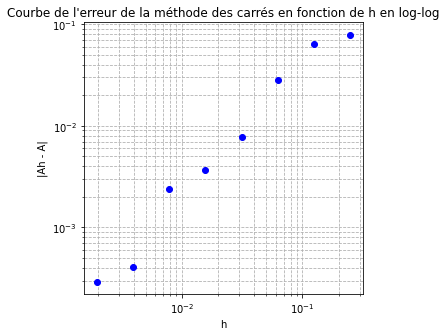

In [37]:
#Application de la méthode pour l'estimation de l'aire A du disque unité : A = pi

def disque_unite(x, y):
    return x**2 + y**2

for i in range (2, 10): 
    plt.plot(2**(-i), np.pi-area_squares(disque_unite, 1., 2**(-i)), 'bo')

plt.yscale('log')
plt.xscale('log') #échelle log-log

plt.xlabel('h')
plt.ylabel('|Ah - A|')

plt.grid(True,which="both", linestyle='--')

plt.title("Courbe de l'erreur de la méthode des carrés en fonction de h en log-log")
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [38]:
def area_squares_encadrement(f,c,h = 0.1):
    N=int((2*2)/h)
    A_inf=0
    A_sup=0
    for i in range(N):
        for j in range(N):
    #pour la minoration il faut que tous les carrés autour soient sous la ligne de niveau
            if (f(-2+i*h,-2+j*h)) <= c and (f(-2+(i+1)*h,-2+j*h)) <= c and (f(-2+i*h,-2+(j+1)*h)) <= c and (f(-2+(i+1)*h,-2+(j+1)*h)) <= c:
                A_inf+=1
    #pour la majoration il suffit que l'un des carrés autour soit sous la ligne de niveau
            if (f(-2+i*h,-2+j*h)) <= c or (f(-2+(i+1)*h,-2+j*h)) <= c or (f(-2+i*h,-2+(j+1)*h)) <= c or (f(-2+(i+1)*h,-2+(j+1)*h)) <= c:
                A_sup+=1
    return (f"{A_inf*(h**2)} < aire < {A_sup*(h**2)}")

In [39]:
#Test d'encadrement de l'aire du cercle unité (pi)
area_squares_encadrement(disque_unite, 1., 0.01)

'3.101 < aire < 3.1814'

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [40]:
# Pour p = (0, 0)

def aire_du_triangle(a, b, c):
    #Pour calculer l'aire du triangle, on utilise la formule Aire = (||a||*||b||*sin(A))/2
    #De plus : ||a||*||b||*sin(A)*u = a^b  où u est un vecteur unitaire
    u = b-a
    v = c-a
    return (u[1]*v[0] - u[0]*v[1])/2 

def Bn(L, p = np.array([0., 0.])): #L est la liste de points décrivant le contour de K
    aire = 0
    for i in range (-1, len(L)-1): # on ballaye tous les points de L en conservant l'indice i+1 dans la liste
        aire += aire_du_triangle(p, np.array(L[i]), np.array(L[i+1]))
    return aire

L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est 3.1363393232666876 pour un pas de 0.1 entre les points du contour


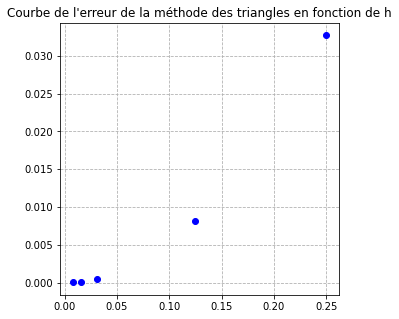

In [41]:
# Application : test de Bn pour le cercle unité

c = 1.

print(f"L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est {Bn(level_curve_bis(disque_unite, 1., 0.,c))} pour un pas de 0.1 entre les points du contour")

#on fait varier le pas entre les points et on regarde l'erreur
for i in range(2,8):
    if i!=4:
        plt.plot(2**(-i), np.pi-Bn(level_curve_bis(disque_unite, 1., 0., c, 2**(-i))), 'bo')

plt.grid(True,which="both", linestyle='--')

plt.title("Courbe de l'erreur de la méthode des triangles en fonction de h")
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

L'aire du cerlce unité mesuré à l'aide de la méthode des triangles est 3.1363393232666876 pour un pas de 0.1 entre les points du contour


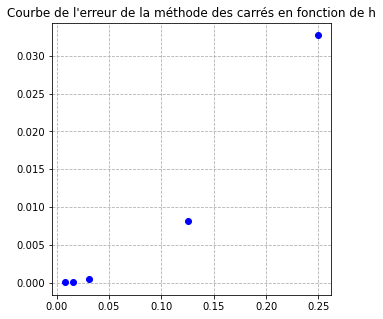

In [42]:
# Application de Bn au cercle unité pour p = (1, 1)
print(f"L'aire du cerlce unité mesurée à l'aide de la méthode des triangles est {Bn(level_curve_bis(disque_unite, 1., 0.,c))} pour un pas de 0.1")

#on fait varier le pas entre les points et on regarde l'erreur
for i in range (2, 8): 
    if i!=4:
        plt.plot(2**(-i), np.pi-Bn(level_curve_bis(disque_unite, 0., 1., c, 2**(-i)), np.array([1., 1.])), 'bo')

plt.grid(True,which="both", linestyle='--')

plt.title("Courbe de l'erreur de la méthode des carrés en fonction de h")
plt.show()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

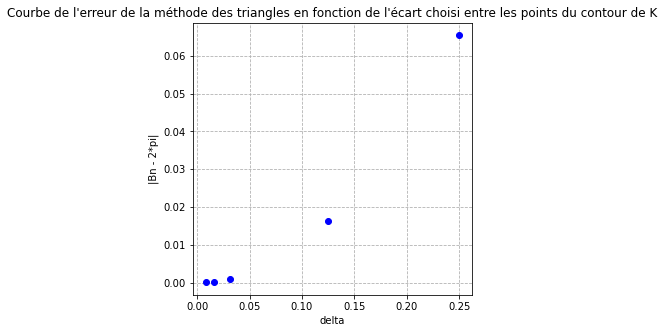

La méthode semble bien fonctionner avec des ensembles non convexes.


In [43]:
# Application de la méthode des triangles sur un ensemble NON CONVEXE de deux cercles

for j in range (2, 8):
    if j!=4:
        L1 = level_curve_bis(disque_unite, 1., 0., c, delta = 2**(-j)) #cercle 1 : de centre (0;0) et de rayon 1
        L2 = np.array([[2 + L1[i][0], L1[i][1]] for i in range (len(L1))]) #cercle 2 (symétrique du cercle 1 par rapport à la droite x = 1)
        L  = np.concatenate((L1, L2), axis=0)

# calcul de l'erreur de la méthode des triangles sur cet ensemble
        plt.plot(2**(-j),(2*np.pi - Bn(L, np.array([1., 0.]))), 'bo')

plt.grid(True,which="both", linestyle='--')
plt.xlabel('delta')
plt.ylabel('|Bn - 2*pi|')
plt.title("Courbe de l'erreur de la méthode des triangles en fonction de l'écart choisi entre les points du contour de K")
plt.show()
print("La méthode semble bien fonctionner avec des ensembles non convexes.")

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [44]:
import time

start = time.time()
a = area_squares(disque_unite, 1., 2**(-6))
finish = time.time()
print(f"Méthode des rectangles : \nLe temps néccessaire pour arriver à la valeur {a} est {finish - start} sec")


start = time.time()
a = Bn(level_curve_bis(disque_unite, 0., 1., c))
finish = time.time()
print(f"Méthode des triangles : \nLe temps néccessaire pour arriver à la valeur {a} est {finish - start} sec \n \n")

print("La méthode la plus rapide (en temps) est donc celle des carrées mais elle est moins précise.")

Méthode des rectangles : 
Le temps néccessaire pour arriver à la valeur 3.137939453125 est 0.06035304069519043 sec
Méthode des triangles : 
Le temps néccessaire pour arriver à la valeur 3.1363393232666876 est 0.18948054313659668 sec 
 

La méthode la plus rapide (en temps) est donc celle des carrées mais elle est moins précise.
